In [1]:
# Imports 
import spacy
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns

from spacy.util import minibatch, compounding
from spacy.training.example import Example
from sklearn.metrics import confusion_matrix, classification_report
import SpacyModel
import importlib

In [2]:
model = None

In [3]:
importlib.reload(SpacyModel)

class GetTripModel(SpacyModel.SpacyNerModel):
    def __init__(self):
        super().__init__(["VILLE_DEPART", "VILLE_DESTINATION"])

    def prepare_data(self, data):
        prepared_data = []
        for item in data:
            text = item['sentence']
            ents = []
            # This model only works with real trip sentences, ie with a departure and an arrival
            if len(item['entities']) != 2:
                continue
            for ent in item['entities']:
                ents.append((ent['start'], ent['end'], ent['label']))
            if len(item['entities']) == 2:
                ent1 = item['entities'][0]
                ent2 = item['entities'][1]
                # Skip the item if the entities overlap
                if ent1['start'] < ent2['end'] and ent1['end'] > ent2['start']:
                    continue

            prepared_data.append((text, {"entities": ents}))
        return prepared_data

# Refresh the methods of the model if it was already instanciated
if model:
    model.__class__ = GetTripModel
    GetTripModel.refresh_methods(model)

In [4]:
# Load data
model = GetTripModel()

# Training

In [5]:
num_positives = len([item for item in model.train_data if len(item[1]["entities"]) > 0])
num_negatives = len([item for item in model.train_data if len(item[1]["entities"]) == 0])
print(f"Exemples positifs : {num_positives}, Exemples négatifs : {num_negatives}")
print(f"Exemple d'entraînement : {model.train_data[0]}")


Exemples positifs : 2412, Exemples négatifs : 0
Exemple d'entraînement : ("je vais de walheim à exideuil-sur-vienne pour un voyage d'affaires lundi prochain.", {'entities': [(11, 18, 'VILLE_DEPART'), (21, 40, 'VILLE_DESTINATION')]})


In [6]:
# Model creation
model.load_model("fr_core_news_md")

In [7]:
# Training
model.train(10, drop=0.30)

Iteration 1, losses : {'ner': 1299.8038863518302}
Iteration 2, losses : {'ner': 73.63461819857893}
Iteration 3, losses : {'ner': 68.46904961055739}
Iteration 4, losses : {'ner': 26.079767509799385}
Iteration 5, losses : {'ner': 65.71446344602445}
Iteration 6, losses : {'ner': 34.452844318634064}
Iteration 7, losses : {'ner': 44.62283582468064}
Iteration 8, losses : {'ner': 13.72346013099636}
Iteration 9, losses : {'ner': 25.027301008719437}
Iteration 10, losses : {'ner': 19.816158603462}


In [8]:
# Save the model
model.save("model_ner_trained")

# Testing

Model: Trained model


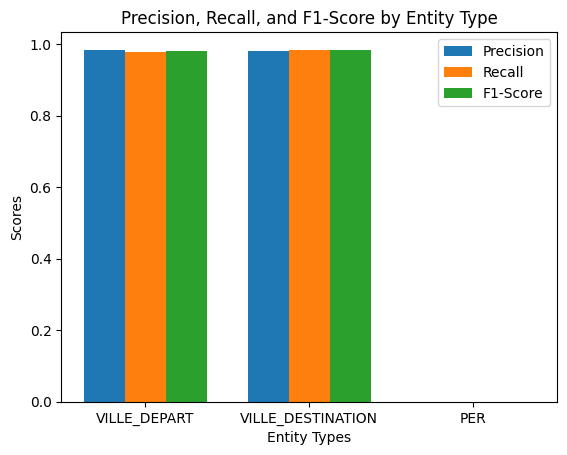

{'token_acc': 1.0,
 'token_p': 1.0,
 'token_r': 1.0,
 'token_f': 1.0,
 'pos_acc': None,
 'morph_acc': None,
 'morph_micro_p': None,
 'morph_micro_r': None,
 'morph_micro_f': None,
 'morph_per_feat': None,
 'sents_p': None,
 'sents_r': None,
 'sents_f': None,
 'dep_uas': None,
 'dep_las': None,
 'dep_las_per_type': None,
 'tag_acc': None,
 'lemma_acc': None,
 'ents_p': 0.9812126387702819,
 'ents_r': 0.982051282051282,
 'ents_f': 0.9816317812900469,
 'ents_per_type': {'VILLE_DEPART': {'p': 0.9828473413379074,
   'r': 0.9794871794871794,
   'f': 0.9811643835616439},
  'VILLE_DESTINATION': {'p': 0.9812606473594548,
   'r': 0.9846153846153847,
   'f': 0.9829351535836178},
  'PER': {'p': 0.0, 'r': 0.0, 'f': 0.0}}}

In [9]:
model.evaluate_model(model.test_data, "Trained model")

# Validation

Model: Trained model


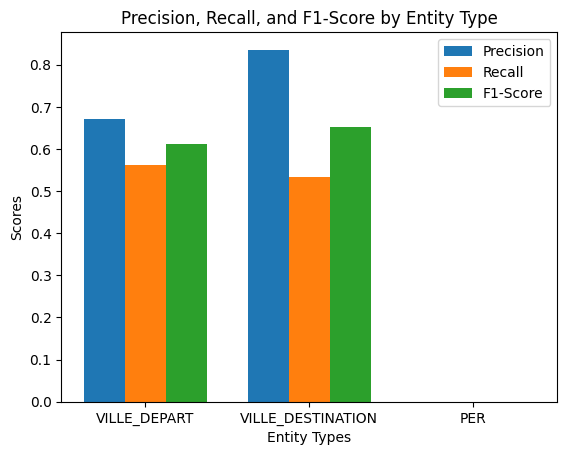

{'token_acc': 1.0,
 'token_p': 1.0,
 'token_r': 1.0,
 'token_f': 1.0,
 'pos_acc': None,
 'morph_acc': None,
 'morph_micro_p': None,
 'morph_micro_r': None,
 'morph_micro_f': None,
 'morph_per_feat': None,
 'sents_p': None,
 'sents_r': None,
 'sents_f': None,
 'dep_uas': None,
 'dep_las': None,
 'dep_las_per_type': None,
 'tag_acc': None,
 'lemma_acc': None,
 'ents_p': 0.7417824466282616,
 'ents_r': 0.54725,
 'ents_f': 0.6298374334628112,
 'ents_per_type': {'VILLE_DEPART': {'p': 0.6710526315789473,
   'r': 0.561,
   'f': 0.6111111111111113},
  'VILLE_DESTINATION': {'p': 0.8355520751761942,
   'r': 0.5335,
   'f': 0.6512053707659445},
  'PER': {'p': 0.0, 'r': 0.0, 'f': 0.0}}}

In [10]:
model.evaluate_model(model.validation_data, "Trained model")